# AutoEncoder Adversario

## Preparacion del entorno

Librerias

In [1]:
import tensorflow as tf
from tensorflow import keras

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from keras import Sequential
from keras.applications import mobilenet
from keras.layers import Input, Dense, LeakyReLU, GlobalAveragePooling2D, Reshape
import numpy as np
import matplotlib.pyplot as plt
import os

Num GPUs Available:  1


Variables globales

In [2]:
ruta = "adversarialautoencoder2.0/wasserstein"
nombre = "AAE2.0_15000e"

Creamos las carpetas para almacenar el output

In [3]:
try:
    os.makedirs(ruta)
except OSError:
    print("Carpeta %s ya existe" % (ruta))
try:
    os.mkdir(ruta+"/output")
except OSError:
    print("Carpeta %s ya existe" % (ruta+"/output"))

Funcion para extraer los datos de los ficheros

In [4]:
# https://www.cs.toronto.edu/~kriz/cifar.html
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin')
    return dict

Extraemos los datos del fichero.

In [5]:
batch1 = unpickle("Input\cifar-10-batches-py\data_batch_1")
batch2 = unpickle("Input\cifar-10-batches-py\data_batch_2")
batch3 = unpickle("Input\cifar-10-batches-py\data_batch_3")
batch4 = unpickle("Input\cifar-10-batches-py\data_batch_4")
batch5 = unpickle("Input\cifar-10-batches-py\data_batch_5")

En cifar10 los datos estan almacenados en un diccionario que contiene el nombre del lote, las etiquetas para clasificacion, los datos (imagenes) y los nombres de fichero correspondientes.

In [6]:
print(batch1.keys())
for i in batch1:
    print(i, type(batch1[i]))

dict_keys(['batch_label', 'labels', 'data', 'filenames'])
batch_label <class 'str'>
labels <class 'list'>
data <class 'numpy.ndarray'>
filenames <class 'list'>


Las imagenes vienen en el modo ``channelsfirst``, en este modo, tenemos 3 matrices de la dimension de la imagen, una para cada canal. Muchas de las funciones admiten por defecto el modo ``chanelslast`` en el que tenemos una matriz de la dimension de la imagen y cada posicion tiene un vector con los codigos de color de cada punto.

Por simplicidad, como paso de preprocesamiento, voy a transformar las imagenes de ``channelsfirst`` a ``channelslast``.

In [7]:
# https://www.binarystudy.com/2021/09/how-to-load-preprocess-visualize-CIFAR-10-and-CIFAR-100.html
imagen = batch1["data"][0]
imagen = imagen.reshape(3,32,32)
imagen=imagen.transpose(1,2,0)
print(imagen.shape)

(32, 32, 3)


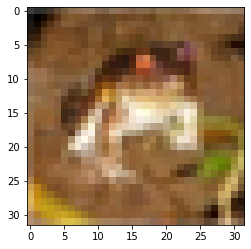

In [8]:
plt.imshow(imagen)

## Preparacion de los datos

Cargamos todas las imagenes de entrenamiento en la variable ``X_train`` y borramos todo lo demás ya que no lo vamos a utilizar.

In [9]:
print(batch1["data"].shape)
X_train = batch1["data"].reshape(10000, 3, 32, 32)
del batch1
X_train = np.concatenate((X_train, batch2["data"].reshape(10000, 3, 32, 32)))
del batch2
X_train = np.concatenate((X_train, batch3["data"].reshape(10000, 3, 32, 32)))
del batch3
X_train = np.concatenate((X_train, batch4["data"].reshape(10000, 3, 32, 32)))
del batch4
X_train = np.concatenate((X_train, batch5["data"].reshape(10000, 3, 32, 32)))
del batch5
X_train = X_train.transpose(0,2,3,1)
X_train=X_train/255

(10000, 3072)


(50000, 32, 32, 3)


<Figure size 432x288 with 0 Axes>

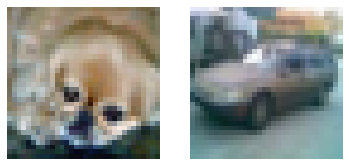

In [10]:
print(X_train.shape)
plt.figure()
f, arrx = plt.subplots(1,2)
arrx[0].imshow(X_train[np.random.randint(0,X_train.shape[0])])
arrx[1].imshow(X_train[np.random.randint(0,X_train.shape[0])])
for a in arrx:
    a.axis("off")

## Arquitectura del ``Autoencoder``

Tamaño de la capa latente:

In [11]:
dim_latente = 20

Tamaño de las imagenes:

In [12]:
img_shape = X_train[0].shape

### Regla de la piramide geometrica

La regla de la piramide geometrica sirve para ayudar determinar el tamaño de las capas ocultas en base al tamaño de las capas de input y output y al numero de capas ocultas. 

Esta aproximacion esta propuesta por Masters(1993): 
>  "For a three layer network with n input and m output neurons, the hidden layer would have sqrt(N * M) neurons."
>
> -- <cite> Masters, Timothy. Pratical neural network recipes in C++. Morgan Kaufmann, 1993.</cite>

[Enlace al artículo](https://eulertech.wordpress.com/2018/01/02/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-network/)

In [13]:
def pyramid_rule(h_layers, input_size, output_size):
    if h_layers < 1:
        print("No layers")
        return
    print("Layers for input %d and output %d:" % (input_size,  output_size))
    rate = (input_size/output_size)**(1/(h_layers+1))
    for l in range(h_layers):
        layer_size = output_size*(rate**(h_layers-l))
        layer_size = round(layer_size)
        print("Layer %d: %d neurons" % (l+1, layer_size))
    return

### EMD(Earth Mover's Distance)

EMD es una medida de distancia entre distribuciones de probabilidad, que consiste en representar ambas distribuciones como montones de tierra, en los que la distancia se determina en cuanto es el trabajo minimo que llevaria transformar un monticulo en otro. Matematicamente a EMD se la conoce como la métrica de Wasserstein.

Segun [este artículo](https://machinelearningmastery.com/how-to-implement-wasserstein-loss-for-generative-adversarial-networks/) esta metrica se puede aplicar de la siguiente manera:

In [14]:
def wasserstein_loss(y_true, y_pred):
	return keras.backend.mean(y_true * y_pred)

### Encoder

El ``encoder`` va a ser un modelo basado en ``transfer learning``, vamos a tomar la red de ``mobilenet``, entranada para imagenes de ``imagenet`` sin las capa de clasificacion final, con una entrada de tamaño _img\_shape_ y en el output colocamos la 'representacion latente' una codificacion de la imagen que nos permitiría reconstruirla con un ``decoder``.

In [15]:
# https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet/preprocess_input
# https://keras.io/guides/transfer_learning/
def build_encoder(dim_latente, img_shape):
    inputs = Input(shape=img_shape)
    x=tf.cast(inputs, tf.float32)
    #x=keras.applications.mobilenet.preprocess_input(x)  #dataformat por defecto es chanel last
    core = mobilenet.MobileNet(input_shape=(img_shape), weights="imagenet", include_top=False)
    core.trainable = False
    model = core(x, training=False)
    model = GlobalAveragePooling2D()(model)
    repr_latente = keras.layers.Dense(dim_latente)(model)
    return keras.Model(inputs, repr_latente)


### Decoder

El ``decoder`` toma la codificacion latente y decodifica en una imagen. En este caso vamos a utilizar la regla de la piramide geometrica para determinar las capas, en este caso van a ser 2 capas ocultas.

In [16]:
pyramid_rule(2, dim_latente, np.prod(img_shape))

Layers for input 20 and output 3072:
Layer 1: 107 neurons
Layer 2: 574 neurons


In [17]:
def build_myDecoder(dim_latente, img_shape):
    model = keras.Sequential()
    model.add(Dense(107, input_dim=dim_latente))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(574))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(np.prod(img_shape), activation=keras.activations.tanh))
    #model.add(ReLU())
    model.add(Reshape(img_shape))
    z = Input(shape=(dim_latente))
    img =  model(z)
    return keras.Model(z,img)

### Discriminator

El discriminador va a tener como entrada la codificacion latente de las imagenes y como salida una neurona que discrimina entre imagenes "reales" y "falsas". De esta forma entrenamos al encoder para que codifique con la distribucion que usemos para generar las "imagenes reales", en este caso, una distribución normal.

In [18]:
pyramid_rule(2, dim_latente, 1)

Layers for input 20 and output 1:
Layer 1: 7 neurons
Layer 2: 3 neurons


In [19]:
def build_discriminator(dim_latente):
    model = Sequential()
    model.add(Dense(7, input_dim=dim_latente))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(3))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation="sigmoid"))
    encoded = Input(shape=dim_latente)
    valid = model(encoded)
    return keras.Model(encoded, valid)

### Red completa

Parametros

In [20]:
optimizer = keras.optimizers.Adam(0.0002, 0.5)
loss=wasserstein_loss
#loss="mse"

Discriminador

In [21]:
discriminator = build_discriminator(dim_latente)
discriminator.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

Encoder y decoder

In [22]:
encoder = build_encoder(dim_latente, img_shape)
decoder = build_myDecoder(dim_latente, img_shape)

Autoencoder

In [23]:
# el encoder toma un imagen y la codifica y el decoder toma la codificacion e intenta regenerar la imagen
img = Input(shape=img_shape)
encoded = encoder(img)
reconstructed = decoder(encoded)

# para el autoencoder adversario solo queremos entrenar el generador, no el discriminador
discriminator.trainable=False

# El discriminador evalua la validez de la codificacion
validez = discriminator(encoded)

# Autoencoder adversario 
a_autoencoder = keras.Model(img, [reconstructed, validez])
a_autoencoder.compile(loss=["mse", "binary_crossentropy"], loss_weights=[0.999, 0.001], optimizer=optimizer)

## Entrenamiento

### Funciones de muestreo

In [24]:
def sample_imgs(dataset, model, epoch, sample_size=5, save_imgs=True):
    # Tomamos sample_size imagenes de muestra
    ids = np.random.randint(0,dataset.shape[0], sample_size)
    sample=dataset[ids]
    # Intentamos regenerar las imagenes
    gen_img = model.predict(sample)[0]
    # Guardamos una grafica con la muestra (arriba) y las imagenes generadas (abajo)
    f, axxs = plt.subplots(2,sample_size)
    for j in range(sample_size):
        axxs[0,j].imshow(sample[j])
        axxs[1,j].imshow(gen_img[j])
    for i in axxs:
        for j in i:
            j.axis("off")
    if save_imgs:
        f.savefig(ruta+"/output/generationCIFAR10_e%d.png" % (epoch))
        plt.close()
    

In [25]:
def true_sampler(dim_latente, batch_size):
    return np.random.normal(size=(batch_size, dim_latente))

In [26]:
def generate_samples(dim_latente, decoder, epoch):
    sample_shape = (5,5)
    latent_samples = true_sampler(dim_latente, np.prod(sample_shape))
    samples=decoder.predict(latent_samples)#*0.5 +0.5
    fig, axxs = plt.subplots(sample_shape[0], sample_shape[1])
    s=0
    for i in range(sample_shape[0]):
        for j in range(sample_shape[1]):
            axxs[i,j].imshow(samples[s])
            axxs[i,j].axis("off")
            s+=1
    fig.savefig(ruta+"\output\\"+nombre+"progresscifar10_e%d.png" % (epoch))
    plt.close()

    

In [27]:
sample_from = unpickle("Input\cifar-10-batches-py\\test_batch")
sample_from = sample_from["data"]
sample_from.shape

(10000, 3072)

In [28]:
sample_from = sample_from.reshape(10000,3,32,32)
sample_from = sample_from.transpose(0,2,3,1)
sample_from = sample_from/255


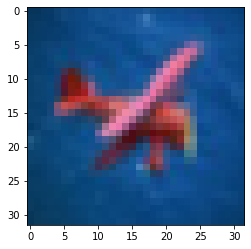

In [29]:
plt.imshow(sample_from[np.random.randint(0,sample_from.shape[0])])

### Ciclo de entrenamiento

In [30]:
# https://github.com/mrquincle/keras-adversarial-autoencoders/blob/master/Keras%20Adversarial%20Autoencoder%20MNIST.ipynb
epochs=15000
batch_size=120
sample_interval=1000

valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

for epoch in range(epochs+1):
    # lote de imagenes
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    latent_fake = encoder.predict(imgs)
    latent_true =true_sampler(dim_latente, batch_size)

    #entrenamos el discriminador
    dis_loss_real = discriminator.train_on_batch(latent_true, valid)
    dis_loss_fake = discriminator.train_on_batch(latent_fake, fake)
    dis_avg_loss = 0.5*np.add(dis_loss_fake, dis_loss_real)

    # entrenamos al autoencoder
    aae_loss = a_autoencoder.train_on_batch(imgs,[imgs, valid])
    
    # monitorizamos el progreso
    if epoch % 10==0:
        print("Epoch: %d Disc: (loss = %f, acc = %.2f%%) AAE: (mse = %f, b_ce = %f)" % (epoch, dis_avg_loss[0], 100*dis_avg_loss[1], aae_loss[0], aae_loss[1]))
    # Hacemos una muestra visual
    if epoch % sample_interval==0:
        # sample_imgs(sample_from, autoencoder, epoch)
        generate_samples(dim_latente, decoder, epoch)


Epoch: 0 Disc: (loss = 0.203635, acc = 65.83%) AAE: (mse = 0.284848, b_ce = 0.284352)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch: 10 Disc: (loss = 0.193953, acc = 63.33%) AAE: (mse = 0.242564, b_ce = 0.242022)
Epoch: 20 Disc: (loss = 0.204391, acc = 66.67%) AAE: (mse = 0.107524, b_ce = 0.106827)
Epoch: 30 Disc: (loss = 0.191478, acc = 62.92%) AAE: (mse = 0.082563, b_ce = 0.081824)
Epoch: 40 Disc: (loss = 0.193699, acc = 60.83%) AAE: (mse = 0.078632, b_ce = 0.077886)
Epoch: 50 Disc: (loss = 0.183295, acc = 62.08%) AAE: (mse = 0.085460, b_ce = 0.084706)
Epoch: 60 Disc: (loss = 0.191138, acc = 61.67%) AAE: (mse = 0.078783, b_ce = 0.078023)
Epoch: 70 Disc: (loss = 0.178228, acc = 62.92%) AAE: (mse = 0.076975, b_ce = 0.076203)
Epoch: 80 Disc: (loss = 0.172548, acc = 60.42%) AAE: (mse = 0.075549, b_ce = 0.074771)
Epoch: 90 Disc: (loss = 0.151903, acc = 55.42%) AAE: (mse = 0.071029, b_ce = 0.070230)
Epoch: 100 Disc: (loss = 0.156358, acc = 56.67%) AAE: (mse = 0.071308, b_ce = 0.070509)
Epoch: 110 Disc: (loss = 0.172092, acc = 59.17%) AAE: (mse = 0.071985, b_ce = 0.071169)
Epoch: 120 Disc: (loss = 0.169274, acc = 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 1010 Disc: (loss = 0.014224, acc = 50.00%) AAE: (mse = 0.062399, b_ce = 0.060439)
Epoch: 1020 Disc: (loss = 0.013593, acc = 50.00%) AAE: (mse = 0.058045, b_ce = 0.056066)
Epoch: 1030 Disc: (loss = 0.014493, acc = 50.00%) AAE: (mse = 0.067045, b_ce = 0.065071)
Epoch: 1040 Disc: (loss = 0.013319, acc = 50.00%) AAE: (mse = 0.066802, b_ce = 0.064808)
Epoch: 1050 Disc: (loss = 0.012664, acc = 50.00%) AAE: (mse = 0.061398, b_ce = 0.059378)
Epoch: 1060 Disc: (loss = 0.013183, acc = 50.00%) AAE: (mse = 0.062111, b_ce = 0.060081)
Epoch: 1070 Disc: (loss = 0.011220, acc = 50.00%) AAE: (mse = 0.064325, b_ce = 0.062292)
Epoch: 1080 Disc: (loss = 0.011726, acc = 50.00%) AAE: (mse = 0.062639, b_ce = 0.060587)
Epoch: 1090 Disc: (loss = 0.012781, acc = 50.00%) AAE: (mse = 0.064769, b_ce = 0.062694)
Epoch: 1100 Disc: (loss = 0.013667, acc = 50.00%) AAE: (mse = 0.062249, b_ce = 0.060161)
Epoch: 1110 Disc: (loss = 0.011947, acc = 50.00%) AAE: (mse = 0.064328, b_ce = 0.062222)
Epoch: 1120 Disc: (lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 2010 Disc: (loss = 0.002116, acc = 50.00%) AAE: (mse = 0.061094, b_ce = 0.057656)
Epoch: 2020 Disc: (loss = 0.001658, acc = 50.00%) AAE: (mse = 0.063400, b_ce = 0.059961)
Epoch: 2030 Disc: (loss = 0.002031, acc = 50.00%) AAE: (mse = 0.066124, b_ce = 0.062668)
Epoch: 2040 Disc: (loss = 0.001579, acc = 50.00%) AAE: (mse = 0.063568, b_ce = 0.060100)
Epoch: 2050 Disc: (loss = 0.001575, acc = 50.00%) AAE: (mse = 0.066925, b_ce = 0.063440)
Epoch: 2060 Disc: (loss = 0.001355, acc = 50.00%) AAE: (mse = 0.068284, b_ce = 0.064787)
Epoch: 2070 Disc: (loss = 0.001924, acc = 50.00%) AAE: (mse = 0.062020, b_ce = 0.058508)
Epoch: 2080 Disc: (loss = 0.001476, acc = 50.00%) AAE: (mse = 0.063910, b_ce = 0.060390)
Epoch: 2090 Disc: (loss = 0.001262, acc = 50.00%) AAE: (mse = 0.068770, b_ce = 0.065232)
Epoch: 2100 Disc: (loss = 0.001469, acc = 50.00%) AAE: (mse = 0.067495, b_ce = 0.063953)
Epoch: 2110 Disc: (loss = 0.001776, acc = 50.00%) AAE: (mse = 0.060649, b_ce = 0.057077)
Epoch: 2120 Disc: (lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 3010 Disc: (loss = 0.000387, acc = 50.00%) AAE: (mse = 0.067139, b_ce = 0.062421)
Epoch: 3020 Disc: (loss = 0.000377, acc = 50.00%) AAE: (mse = 0.065014, b_ce = 0.060286)
Epoch: 3030 Disc: (loss = 0.000355, acc = 50.00%) AAE: (mse = 0.066201, b_ce = 0.061461)
Epoch: 3040 Disc: (loss = 0.000394, acc = 50.00%) AAE: (mse = 0.063396, b_ce = 0.058641)
Epoch: 3050 Disc: (loss = 0.000309, acc = 50.00%) AAE: (mse = 0.061625, b_ce = 0.056855)
Epoch: 3060 Disc: (loss = 0.000342, acc = 50.00%) AAE: (mse = 0.066441, b_ce = 0.061659)
Epoch: 3070 Disc: (loss = 0.000370, acc = 50.00%) AAE: (mse = 0.065347, b_ce = 0.060561)
Epoch: 3080 Disc: (loss = 0.000377, acc = 50.00%) AAE: (mse = 0.061093, b_ce = 0.056289)
Epoch: 3090 Disc: (loss = 0.000333, acc = 50.00%) AAE: (mse = 0.068034, b_ce = 0.063224)
Epoch: 3100 Disc: (loss = 0.000354, acc = 50.00%) AAE: (mse = 0.065868, b_ce = 0.061045)
Epoch: 3110 Disc: (loss = 0.000414, acc = 50.00%) AAE: (mse = 0.060804, b_ce = 0.055971)
Epoch: 3120 Disc: (lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 4010 Disc: (loss = 0.000125, acc = 50.00%) AAE: (mse = 0.066265, b_ce = 0.060361)
Epoch: 4020 Disc: (loss = 0.000104, acc = 50.00%) AAE: (mse = 0.061241, b_ce = 0.055329)
Epoch: 4030 Disc: (loss = 0.000101, acc = 50.00%) AAE: (mse = 0.072266, b_ce = 0.066350)
Epoch: 4040 Disc: (loss = 0.000077, acc = 50.00%) AAE: (mse = 0.070608, b_ce = 0.064678)
Epoch: 4050 Disc: (loss = 0.000126, acc = 50.00%) AAE: (mse = 0.068251, b_ce = 0.062302)
Epoch: 4060 Disc: (loss = 0.000087, acc = 50.00%) AAE: (mse = 0.065704, b_ce = 0.059749)
Epoch: 4070 Disc: (loss = 0.000083, acc = 50.00%) AAE: (mse = 0.068317, b_ce = 0.062347)
Epoch: 4080 Disc: (loss = 0.000087, acc = 50.00%) AAE: (mse = 0.065247, b_ce = 0.059269)
Epoch: 4090 Disc: (loss = 0.000089, acc = 50.00%) AAE: (mse = 0.060512, b_ce = 0.054519)
Epoch: 4100 Disc: (loss = 0.000109, acc = 50.00%) AAE: (mse = 0.067751, b_ce = 0.061760)
Epoch: 4110 Disc: (loss = 0.000088, acc = 50.00%) AAE: (mse = 0.064055, b_ce = 0.058045)
Epoch: 4120 Disc: (lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 5010 Disc: (loss = 0.000028, acc = 50.00%) AAE: (mse = 0.063658, b_ce = 0.056655)
Epoch: 5020 Disc: (loss = 0.000033, acc = 50.00%) AAE: (mse = 0.068889, b_ce = 0.061880)
Epoch: 5030 Disc: (loss = 0.000032, acc = 50.00%) AAE: (mse = 0.069593, b_ce = 0.062565)
Epoch: 5040 Disc: (loss = 0.000030, acc = 50.00%) AAE: (mse = 0.063261, b_ce = 0.056222)
Epoch: 5050 Disc: (loss = 0.000027, acc = 50.00%) AAE: (mse = 0.063624, b_ce = 0.056582)
Epoch: 5060 Disc: (loss = 0.000024, acc = 50.00%) AAE: (mse = 0.069148, b_ce = 0.062088)
Epoch: 5070 Disc: (loss = 0.000028, acc = 50.00%) AAE: (mse = 0.070030, b_ce = 0.062966)
Epoch: 5080 Disc: (loss = 0.000024, acc = 50.00%) AAE: (mse = 0.069111, b_ce = 0.062035)
Epoch: 5090 Disc: (loss = 0.000027, acc = 50.00%) AAE: (mse = 0.068185, b_ce = 0.061104)
Epoch: 5100 Disc: (loss = 0.000029, acc = 50.00%) AAE: (mse = 0.067723, b_ce = 0.060623)
Epoch: 5110 Disc: (loss = 0.000027, acc = 50.00%) AAE: (mse = 0.061293, b_ce = 0.054185)
Epoch: 5120 Disc: (lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch: 6010 Disc: (loss = 0.000008, acc = 50.00%) AAE: (mse = 0.064836, b_ce = 0.056777)
Epoch: 6020 Disc: (loss = 0.000008, acc = 50.00%) AAE: (mse = 0.067988, b_ce = 0.059920)
Epoch: 6030 Disc: (loss = 0.000009, acc = 50.00%) AAE: (mse = 0.069731, b_ce = 0.061657)
Epoch: 6040 Disc: (loss = 0.000011, acc = 50.00%) AAE: (mse = 0.069402, b_ce = 0.061313)
Epoch: 6050 Disc: (loss = 0.000007, acc = 50.00%) AAE: (mse = 0.072641, b_ce = 0.064544)
Epoch: 6060 Disc: (loss = 0.000006, acc = 50.00%) AAE: (mse = 0.071037, b_ce = 0.062924)
Epoch: 6070 Disc: (loss = 0.000008, acc = 50.00%) AAE: (mse = 0.072467, b_ce = 0.064344)
Epoch: 6080 Disc: (loss = 0.000012, acc = 50.00%) AAE: (mse = 0.068052, b_ce = 0.059921)
Epoch: 6090 Disc: (loss = 0.000007, acc = 50.00%) AAE: (mse = 0.070075, b_ce = 0.061930)
Epoch: 6100 Disc: (loss = 0.000007, acc = 50.00%) AAE: (mse = 0.066476, b_ce = 0.058321)
Epoch: 6110 Disc: (loss = 0.000005, acc = 50.00%) AAE: (mse = 0.061595, b_ce = 0.053419)
Epoch: 6120 Disc: (lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 7010 Disc: (loss = 0.000002, acc = 50.00%) AAE: (mse = 0.070832, b_ce = 0.061726)
Epoch: 7020 Disc: (loss = 0.000002, acc = 50.00%) AAE: (mse = 0.070580, b_ce = 0.061457)
Epoch: 7030 Disc: (loss = 0.000003, acc = 50.00%) AAE: (mse = 0.069746, b_ce = 0.060620)
Epoch: 7040 Disc: (loss = 0.000003, acc = 50.00%) AAE: (mse = 0.064806, b_ce = 0.055652)
Epoch: 7050 Disc: (loss = 0.000003, acc = 50.00%) AAE: (mse = 0.072570, b_ce = 0.063423)
Epoch: 7060 Disc: (loss = 0.000004, acc = 50.00%) AAE: (mse = 0.067946, b_ce = 0.058782)
Epoch: 7070 Disc: (loss = 0.000003, acc = 50.00%) AAE: (mse = 0.068404, b_ce = 0.059232)
Epoch: 7080 Disc: (loss = 0.000002, acc = 50.00%) AAE: (mse = 0.066953, b_ce = 0.057770)
Epoch: 7090 Disc: (loss = 0.000002, acc = 50.00%) AAE: (mse = 0.069803, b_ce = 0.060613)
Epoch: 7100 Disc: (loss = 0.000003, acc = 50.00%) AAE: (mse = 0.063037, b_ce = 0.053822)
Epoch: 7110 Disc: (loss = 0.000002, acc = 50.00%) AAE: (mse = 0.069634, b_ce = 0.060422)
Epoch: 7120 Disc: (lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch: 8010 Disc: (loss = 0.000001, acc = 50.00%) AAE: (mse = 0.078241, b_ce = 0.068109)
Epoch: 8020 Disc: (loss = 0.000001, acc = 50.00%) AAE: (mse = 0.071130, b_ce = 0.060981)
Epoch: 8030 Disc: (loss = 0.000001, acc = 50.00%) AAE: (mse = 0.075452, b_ce = 0.065296)
Epoch: 8040 Disc: (loss = 0.000001, acc = 50.00%) AAE: (mse = 0.068850, b_ce = 0.058679)
Epoch: 8050 Disc: (loss = 0.000001, acc = 50.00%) AAE: (mse = 0.069159, b_ce = 0.058968)
Epoch: 8060 Disc: (loss = 0.000001, acc = 50.00%) AAE: (mse = 0.068798, b_ce = 0.058612)
Epoch: 8070 Disc: (loss = 0.000001, acc = 50.00%) AAE: (mse = 0.069561, b_ce = 0.059350)
Epoch: 8080 Disc: (loss = 0.000001, acc = 50.00%) AAE: (mse = 0.071626, b_ce = 0.061423)
Epoch: 8090 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.070061, b_ce = 0.059848)
Epoch: 8100 Disc: (loss = 0.000001, acc = 50.00%) AAE: (mse = 0.071476, b_ce = 0.061246)
Epoch: 8110 Disc: (loss = 0.000001, acc = 50.00%) AAE: (mse = 0.071839, b_ce = 0.061597)
Epoch: 8120 Disc: (lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 9010 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.070853, b_ce = 0.059656)
Epoch: 9020 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.068145, b_ce = 0.056934)
Epoch: 9030 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.074393, b_ce = 0.063186)
Epoch: 9040 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.076244, b_ce = 0.065031)
Epoch: 9050 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.072192, b_ce = 0.060962)
Epoch: 9060 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.073831, b_ce = 0.062597)
Epoch: 9070 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.067689, b_ce = 0.056443)
Epoch: 9080 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.071523, b_ce = 0.060253)
Epoch: 9090 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.074266, b_ce = 0.063011)
Epoch: 9100 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.067789, b_ce = 0.056500)
Epoch: 9110 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.076120, b_ce = 0.064818)
Epoch: 9120 Disc: (lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch: 10010 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.074684, b_ce = 0.062437)
Epoch: 10020 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.072010, b_ce = 0.059744)
Epoch: 10030 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.077162, b_ce = 0.064905)
Epoch: 10040 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.074458, b_ce = 0.062199)
Epoch: 10050 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.075952, b_ce = 0.063673)
Epoch: 10060 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.076740, b_ce = 0.064458)
Epoch: 10070 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.073977, b_ce = 0.061662)
Epoch: 10080 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.070751, b_ce = 0.058451)
Epoch: 10090 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.071551, b_ce = 0.059228)
Epoch: 10100 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.073438, b_ce = 0.061115)
Epoch: 10110 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.072107, b_ce = 0.059751)
Epoch: 101

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch: 11010 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.075642, b_ce = 0.062369)
Epoch: 11020 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.072966, b_ce = 0.059686)
Epoch: 11030 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.075086, b_ce = 0.061766)
Epoch: 11040 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.079583, b_ce = 0.066283)
Epoch: 11050 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.070979, b_ce = 0.057672)
Epoch: 11060 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.066751, b_ce = 0.053422)
Epoch: 11070 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.071856, b_ce = 0.058523)
Epoch: 11080 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.071259, b_ce = 0.057929)
Epoch: 11090 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.075302, b_ce = 0.061943)
Epoch: 11100 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.074462, b_ce = 0.061096)
Epoch: 11110 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.074502, b_ce = 0.061141)
Epoch: 111

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch: 12010 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.077040, b_ce = 0.062798)
Epoch: 12020 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.078345, b_ce = 0.064106)
Epoch: 12030 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.075908, b_ce = 0.061635)
Epoch: 12040 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.074328, b_ce = 0.060042)
Epoch: 12050 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.073339, b_ce = 0.059042)
Epoch: 12060 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.072126, b_ce = 0.057836)
Epoch: 12070 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.072906, b_ce = 0.058594)
Epoch: 12080 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.076643, b_ce = 0.062301)
Epoch: 12090 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.073525, b_ce = 0.059207)
Epoch: 12100 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.076753, b_ce = 0.062429)
Epoch: 12110 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.072783, b_ce = 0.058433)
Epoch: 121

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch: 13010 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.076734, b_ce = 0.061594)
Epoch: 13020 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.071716, b_ce = 0.056568)
Epoch: 13030 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.072432, b_ce = 0.057279)
Epoch: 13040 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.077657, b_ce = 0.062475)
Epoch: 13050 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.071700, b_ce = 0.056515)
Epoch: 13060 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.072243, b_ce = 0.057064)
Epoch: 13070 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.078474, b_ce = 0.063295)
Epoch: 13080 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.075375, b_ce = 0.060171)
Epoch: 13090 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.072281, b_ce = 0.057083)
Epoch: 13100 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.076570, b_ce = 0.061337)
Epoch: 13110 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.073133, b_ce = 0.057915)
Epoch: 131

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Epoch: 14010 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.082700, b_ce = 0.066800)
Epoch: 14020 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.079109, b_ce = 0.063219)
Epoch: 14030 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.075799, b_ce = 0.059897)
Epoch: 14040 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.070155, b_ce = 0.054262)
Epoch: 14050 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.073643, b_ce = 0.057759)
Epoch: 14060 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.075947, b_ce = 0.060027)
Epoch: 14070 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.073786, b_ce = 0.057867)
Epoch: 14080 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.076490, b_ce = 0.060561)
Epoch: 14090 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.074437, b_ce = 0.058525)
Epoch: 14100 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.077338, b_ce = 0.061387)
Epoch: 14110 Disc: (loss = 0.000000, acc = 50.00%) AAE: (mse = 0.072803, b_ce = 0.056866)
Epoch: 141

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

In [31]:
import os.path

savefile = ruta+"/"+nombre+".h5"

if not os.path.isfile(savefile):
    a_autoencoder.save(savefile)
else:
    print("Ya hay un modelo guardado en "+savefile)

El autoencoder parece ser incapaz de reconstruir las imagenes de la entrada

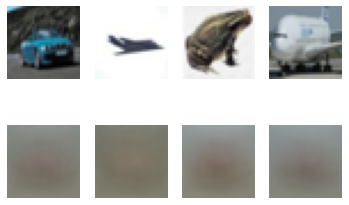

In [33]:
sample_imgs(sample_from, a_autoencoder, 0, 4, False)

Esto tambien sucede con el autoencoder sin la parte del discriminador cuando no se permite entrenar al encoder (inicializado con los pesos de imagenet).

Sin embargo si permitimos entrenar al encoder del autoencoder adversario, los resultados de generar imagenes con el decoder son estos: 

![aa](./adversarialautoencoder2.0/AAE_encoder_entrenado.png)